In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from nltk import FreqDist
from wordcloud import WordCloud
from pathlib import Path

##### Se consulta los datos en la pagina oficial de Conagua, se pasan los datos manualmente desde el año 2020 al 2025 a un archivo Excel para cada año https://smn.conagua.gob.mx/es/climatologia/temperaturas-y-lluvias/resumenes-mensuales-de-temperaturas-y-lluvias.

Se sube a un diccionario vacio los csv que se tienen

In [2]:
carpeta = Path(r"C:\Users\sayur\Downloads\Proyecto_Bedu\data\utf8")
dataframes = {}  # diccionario vacío

for archivo in carpeta.glob('*.csv'):
    nombre_tabla = archivo.stem
    dataframes[nombre_tabla] = pd.read_csv(archivo, dtype=str, low_memory=False, na_filter=True)

In [3]:
# se confirma si se subieron los csv
for k in dataframes.keys():
    print(k)

2020
2021
2022
2023
2024
2025


In [4]:
df_2025=dataframes["2025"]
df_2024=dataframes["2024"]
df_2023=dataframes["2023"]
df_2022=dataframes["2022"]
df_2021=dataframes["2021"]
df_2020=dataframes["2020"]

In [5]:
# primeras filas para verificar que se haya subido bien el csv y se le definio su var
df_2025.head(2)

,Estado,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic,Anual
0,Aguascalientes,9.5,0.0,0.0,0.1,32.7,157.8,143.8,139.3,483.2,NaN,NaN,NaN,NaN
1,BajaCalifornia,3.8,4.7,28.9,3.2,2.4,5.4,0.3,7.8,56.4,NaN,NaN,NaN,NaN


En esta parte se realiza la limpieza y normalizacion de los datos que trabajaremos, se hace la conversion de minusculas y los datos numericos a tipo float, tambien el manejo de nulos

In [6]:
for anio, df in dataframes.items():
    # columnas a minusculas
    df.columns = df.columns.str.lower()

    # contenido a minusculas en columnas con valores tipo object
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].map(lambda x: x.lower() if isinstance(x, str) else x)

        # reemplazar valores de texto que representan nulos por NaN real
        df[col] = df[col].replace(
            ["nan", "null", "none", "na", "", " "], 
            np.nan
        )
        # convertir a valores numericos
        for col in df.select_dtypes(include="object").columns:
            try:
                df[col] = df[col].astype(float)
            except ValueError:
                pass


    dataframes[anio] = df

In [7]:
# primeras filas para ver si se convirtierona  minusculas 
df_2025.head(2)

,estado,ene,feb,mar,abr,may,jun,jul,ago,sep,oct,nov,dic,anual
0,aguascalientes,9.5,0.0,0.0,0.1,32.7,157.8,143.8,139.3,483.2,NaN,NaN,NaN,NaN
1,bajacalifornia,3.8,4.7,28.9,3.2,2.4,5.4,0.3,7.8,56.4,NaN,NaN,NaN,NaN


In [8]:
# Se hace la exploracion del tipo de datos que sean correctos. 

df_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   estado  33 non-null     object 
 1   ene     33 non-null     float64
 2   feb     33 non-null     float64
 3   mar     33 non-null     float64
 4   abr     33 non-null     float64
 5   may     33 non-null     float64
 6   jun     33 non-null     float64
 7   jul     33 non-null     float64
 8   ago     33 non-null     float64
 9   sep     33 non-null     float64
 10  oct     0 non-null      float64
 11  nov     0 non-null      float64
 12  dic     0 non-null      float64
 13  anual   0 non-null      float64
dtypes: float64(13), object(1)
memory usage: 3.7+ KB


Se comienza con el apartado de estimados de locación y variabilidad 

In [9]:
resultados = {}

for anio, df in dataframes.items():
    num = df.select_dtypes(include=["number"]).copy()

    # deteccion de valores atipicos con IQR
    Q1 = num.quantile(0.25)
    Q3 = num.quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR

    # mascara de valores validos
    mask = ~((num < lim_inf) | (num > lim_sup))
    num_sin_outliers = num.where(mask, np.nan)

    # estimadores de locación 
    locacion = pd.DataFrame({
        "media": num_sin_outliers.mean(),
        "mediana": num_sin_outliers.median(),
        "moda": num_sin_outliers.mode().iloc[0]
    })

    # estimadores de variabilidad 
    variabilidad = pd.DataFrame({
        "rango": num_sin_outliers.max() - num_sin_outliers.min(),
        "varianza": num_sin_outliers.var(),
        "desviacion_estandar": num_sin_outliers.std(),
        "coef_var_%": (num_sin_outliers.std() / num_sin_outliers.mean()) * 100
    })

    # estadisticos de orden
    orden = pd.DataFrame({
        "minimo": num_sin_outliers.min(),
        "Q1": num_sin_outliers.quantile(0.25),
        "mediana": num_sin_outliers.median(),
        "Q3": num_sin_outliers.quantile(0.75),
        "maximo": num_sin_outliers.max()
    })

    # concatena los resultados
    resumen = pd.concat([locacion, variabilidad, orden], axis=1)
    resultados[anio] = resumen


Años disponibles: ['2020', '2021', '2022', '2023', '2024', '2025']


Selecciona un año:  2020



Columnas disponibles: ['media', 'mediana', 'moda', 'rango', 'varianza', 'desviacion_estandar', 'coef_var_%', 'minimo', 'Q1', 'mediana', 'Q3', 'maximo']


Selecciona la columna a graficar:  media



Tipos de gráfico disponibles: barra, linea, histograma, boxplot


Selecciona el tipo de gráfico:  barra


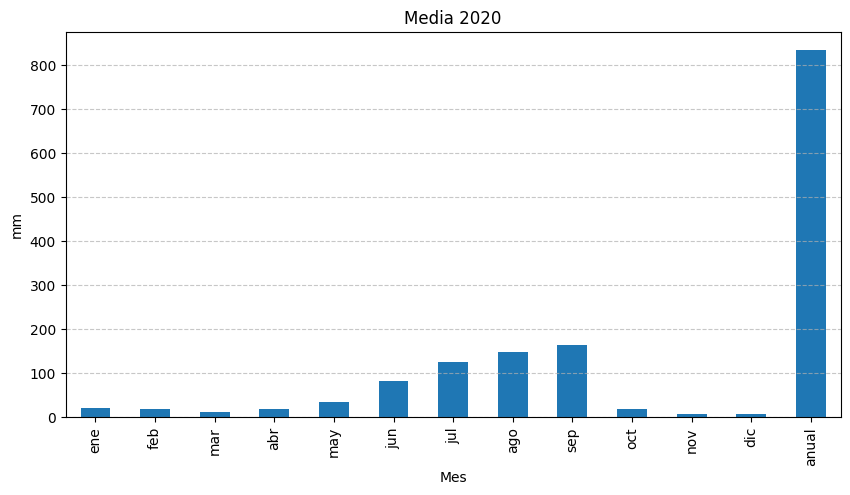

In [10]:
# mostrar años disponibles
print("Años disponibles:", list(resultados.keys()))
anio = input("Selecciona un año: ")

if anio.isdigit() and str(anio) in resultados:
    anio = str(anio)
    df = resultados[anio]

    print("\nColumnas disponibles:", list(df.columns))
    columna = input("Selecciona la columna a graficar: ")

    print("\nTipos de gráfico disponibles: barra, linea, histograma, boxplot")
    tipo = input("Selecciona el tipo de gráfico: ").lower()

    plt.figure(figsize=(10,5))

    if tipo == "barra":
        df[columna].plot(kind="bar", title=f"{columna.capitalize()} {anio}")
    elif tipo == "linea":
        df[columna].plot(kind="line", marker="o", title=f"{columna.capitalize()} {anio}")
    elif tipo == "histograma":
        plt.hist(df[columna].dropna(), bins=10)
        plt.title(f"Histograma de {columna} ({anio})")
    elif tipo == "boxplot":
        plt.boxplot(df[columna].dropna())
        plt.title(f"Boxplot de {columna} ({anio})")
    else:
        print("Tipo de gráfico no válido.")
    
    plt.ylabel("mm")
    plt.xlabel("Mes")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

else:
    print("Año no válido.")


#### No es necesario realizar un análisis exhaustivo de variables categóricas en este conjunto de datos, ya que el contenido se centra principalmente en variables numéricas continuas, como la precipitación en milímetros, y solo cuenta con categorías simples como “mes” y “estado”. Estas variables categóricas no interactúan entre sí de manera que justifique el uso de tablas de contingencia o pruebas de asociación, puesto que su función es únicamente identificar la ubicación temporal y geográfica de los registros. En este caso, el enfoque más adecuado es el análisis descriptivo y comparativo de la precipitación mediante estimadores de tendencia central y dispersión, complementado con visualizaciones gráficas por estado y mes que permiten interpretar la variabilidad y los patrones climáticos sin requerir un análisis categórico adicional.

#### No se puede realizar la correlacion en este analisis, ya que no hay variables numericas distintas para encontrar una asociarlas en la actividad. 

Años disponibles: ['2020', '2021', '2022', '2023', '2024', '2025']


Selecciona un año:  2020


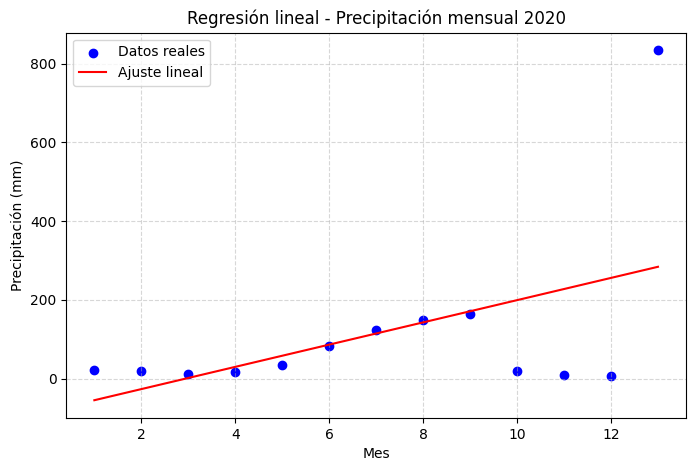


=== RESULTADOS DE REGRESIÓN ===
Pendiente: 28.233
Intercepto: -83.145
Coeficiente de determinación R²: 0.242
Interpretación: la precipitación tiende a aumentar conforme avanza el año.


In [12]:
# mostrar años disponibles
print("Años disponibles:", list(resultados.keys()))
anio = input("Selecciona un año: ")

try:
    anio = str(anio)
    df = resultados[anio].reset_index()

    
    # REGRESIÓN LINEAL SIMPLE
    # si no existe columna numérica para mes, crearla
    if "mes" in df.columns:
        df["mes_num"] = pd.factorize(df["mes"])[0] + 1
    else:
        df["mes_num"] = np.arange(1, len(df) + 1)

    X = df[["mes_num"]].values
    y = df["media"].values

    modelo = LinearRegression().fit(X, y)
    pendiente = modelo.coef_[0]
    intercepto = modelo.intercept_
    r2 = modelo.score(X, y)

    # gráfico
    plt.figure(figsize=(8, 5))
    plt.scatter(df["mes_num"], y, color="blue", label="Datos reales")
    plt.plot(df["mes_num"], modelo.predict(X), color="red", label="Ajuste lineal")
    plt.title(f"Regresión lineal - Precipitación mensual {anio}")
    plt.xlabel("Mes")
    plt.ylabel("Precipitación (mm)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.show()

    # RESULTADOS NUMÉRICOS
    print("\n=== RESULTADOS DE REGRESIÓN ===")
    print(f"Pendiente: {pendiente:.3f}")
    print(f"Intercepto: {intercepto:.3f}")
    print(f"Coeficiente de determinación R²: {r2:.3f}")

    if pendiente > 0:
        print("Interpretación: la precipitación tiende a aumentar conforme avanza el año.")
    elif pendiente < 0:
        print("Interpretación: la precipitación tiende a disminuir conforme avanza el año.")
    else:
        print("Interpretación: no se observa una tendencia lineal significativa.")

except (KeyError, ValueError):
    print("Año no válido o datos no disponibles.")